<h3>Kernel Density Estimation</h3>

This section will use the Kernel Density Estimation (KDE) methods to identify locations in San Francisco (SF) that see the highest amount of bike crashes. The KDE method combined with GeoPandas will help visualize crash hotspots around SF. 

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from math import radians
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [9]:
crashes = pd.read_csv("data/Crashes.csv")
crashes = crashes.dropna(subset=['POINT_X', 'POINT_Y'])

In [18]:
#Cleaning data set so that latitudinal and longitudinal outliers are ignored
crashes_clean = crashes[
    (crashes['POINT_X'] > -123) & (crashes['POINT_X'] < -121) &  # reasonable longitudes
    (crashes['POINT_Y'] > 37)   & (crashes['POINT_Y'] < 38.5) ].copy()   # reasonable latitudes

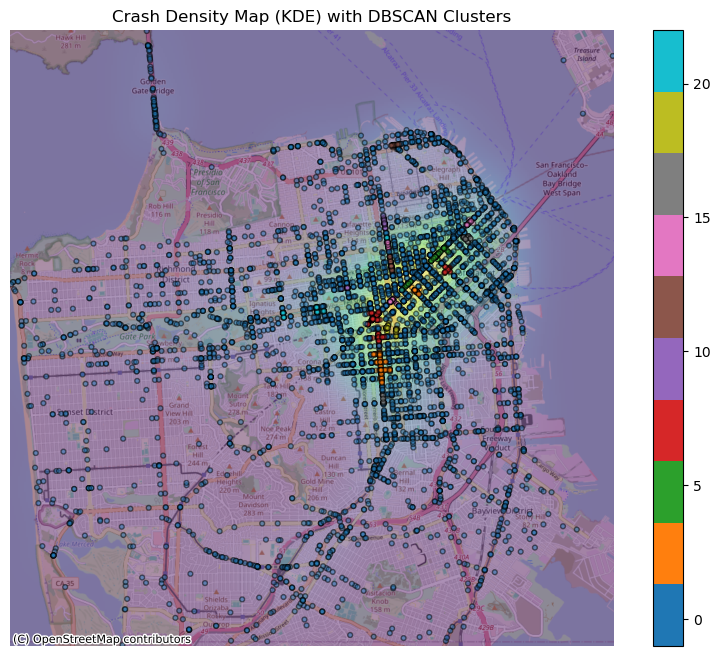

In [30]:
# Turn latitude and longitude into radians for the DBSCAN Haversine method
crashes_clean['lat_rad'] = crashes_clean['POINT_Y'].apply(radians)
crashes_clean['lon_rad'] = crashes_clean['POINT_X'].apply(radians)
coords_rad = crashes_clean[['lat_rad', 'lon_rad']].values

# Mark radius of the cluster
eps_meters = 100
eps_radians = eps_meters / 6371000.0

#Run DBSCAN, defining how many crashes will be in a cluster, noting haversine method
db = DBSCAN(
    eps=eps_radians,
    min_samples=20,
    metric='haversine'
).fit(coords_rad)  

#Set cluster IDs
crashes_clean['cluster'] = db.labels_

# Build points given geometry of crashes
crashes_clean['geometry'] = crashes_clean.apply(
    lambda row: Point(row['POINT_X'], row['POINT_Y']),
    axis=1 )

# Get geodata frame to plot on map
gdf = gpd.GeoDataFrame(crashes_clean, geometry='geometry', crs='EPSG:4326')

# Reproject to turn from radians into meters for map
gdf = gdf.to_crs(epsg=3857)

# Get projected points for KDE analysis
x = gdf.geometry.x.values
y = gdf.geometry.y.values

# Build grid over study area for eventual figure and KDE density surface
xmin, ymin, xmax, ymax = gdf.total_bounds
xi, yi = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]

# Run KDE
kde = gaussian_kde([x, y]) 
zi = kde(np.vstack([xi.flatten(), yi.flatten()]))
zi = zi.reshape(xi.shape)

# Figure with clusters, mesh, and underlying map
fig, ax = plt.subplots(figsize=(10, 8))

ax.pcolormesh(xi, yi, zi, shading='auto', cmap='viridis', alpha=0.45)

# Points colored by cluster label
gdf.plot(
    ax=ax,
    column='cluster',
    cmap='tab10',
    markersize=12,
    alpha=0.5,
    edgecolor='black',
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Crash Density Map (KDE) with DBSCAN Clusters")
plt.show()
